## **Imports**

In [2]:
USING_COLAB = True

In [3]:
if USING_COLAB:

    # loading data
  !gdown 1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
  !gdown 12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
  !gdown 1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
  !gdown 1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
  !gdown 1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo

Downloading...
From: https://drive.google.com/uc?id=1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
To: /content/graph.csv
100% 5.75M/5.75M [00:00<00:00, 30.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
To: /content/submission.csv
100% 131k/131k [00:00<00:00, 4.34MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
To: /content/test2_X.csv
100% 40.0M/40.0M [00:01<00:00, 36.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
To: /content/train_X.csv
100% 87.8M/87.8M [00:01<00:00, 87.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo
To: /content/train_y.csv
100% 514k/514k [00:00<00:00, 7.49MB/s]


In [4]:
# Other tools
import pickle
import random
import os

from collections import Counter
from tqdm import tqdm
from copy import deepcopy

# Train
from sklearn.model_selection import KFold, StratifiedGroupKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import pandas as pd
import numpy as np

from datetime import datetime
from imblearn.over_sampling import SMOTE

# Model
import lightgbm as lgb
import xgboost as xgb


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Session settings
pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'

# make results reproducable
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(SEED)

SEED = 69
set_seed(SEED)

## **New preprocessing function**

In [6]:
def preprocess_data(train, test, delete_corr_features=True, scale=True, init_features2drop=None):

    ts_features2drop = ['agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__8W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W', 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__8W', 'agg_cec_requests__g_contract__request_id__all__count__4W', 'agg_cec_requests__g_contract__request_id__all__count__5W', 'agg_cec_requests__g_contract__request_id__all__count__7W', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME', 'counteragent_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__request_id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__12M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__5M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__6M', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__7M', 'agg_ks2__g_contract__id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__12W', 'agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__8M', 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__4W', 'agg_workers__g_contract__fact_workers__all__mean__3W', 'agg_workers__g_contract__fact_workers__all__mean__26W', 'agg_workers__g_contract__fact_workers__all__mean__6W', 'agg_workers__g_contract__fact_workers__all__mean__12W', 'agg_workers__g_contract__fact_workers__all__mean__8W', 'agg_workers__g_contract__fact_workers__all__mean__5W', 'agg_Finance__g_contractor__Value__CostPrice_y__last__ALL_TIME', 'agg_Finance__g_contractor__Value__NetProfit_y__last__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__6W', 'agg_spass_applications__g_contract__appl_count_week__mean__26W', 'agg_spass_applications__g_contract__appl_count_week__max__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__12W', 'agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__4W', 'agg_spass_applications__g_contract__appl_count_week__mean__4W', 'agg_payments__g_contract__sum__all__countDistinct__2W', 'agg_scontrol__g_contractor__close_delay__defect_type_app__mean__ALL_TIME', 'agg_ks2__g_contract__id__all__count__2W', 'agg_ks2__g_contract__id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__4W', 'agg_ks2__g_contract__id__all__count__4W', 'agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W', 'agg_payments__g_contract__sum__all__countDistinct__12W', 'agg_payments__g_contract__sum__all__sum__8W', 'agg_materials__g_contract__order_id__countDistinct__12W', 'agg_materials__g_contract__material_id__countDistinct__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__8W', 'agg_payments__g_contract__sum__all__countDistinct__ALL_TIME', 'agg_payments__g_contract__date__advance__min__ALL_TIME', 'agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_ks2__g_contract__total_sum__all__sum__8W', 'agg_ks2__g_contract__id__all__count__12W', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__4M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_24M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_36M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_24M', 'agg_Finance__g_contractor__Value__CurrentAssets__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Balance__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Capital__last__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__1W', 'agg_sroomer__g_contractor__sroomer_id__count__12M', 'agg_sroomer__g_contractor__sroomer_id__count__6M', 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME', 'agg_sroomer__g_contractor__sroomer_id__count__3M', 'agg_ks2__g_contract__total_sum__all__sum__12W', 'agg_cec_requests__g_contract__created_dt__accepted__min__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__1W']
    constant_features_names = ['agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CompanySizeRevenue__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME', 'contract_date', 'contract_init_sum', 'agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedNetLiabilitiesSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedClaimsSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME']

    if delete_corr_features:
        train = train.drop(columns=ts_features2drop)
        test = test.drop(columns=ts_features2drop)

    # for now lets drop columns where num of nans is greater that  a half of df length
    isna_stat = train.isna().sum()[train.isna().sum() > 0]
    features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (3/5))]
    train.drop(columns=features2drop, inplace=True)
    test.drop(columns=features2drop, inplace=True)

    # other we`ll fill with median
    for col in isna_stat.index:
        if col not in features2drop:
            imp = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
            train[col] = imp.transform(train[col].values.reshape(-1, 1))
            test[col] = imp.transform(test[col].values.reshape(-1, 1))

    #translate to timestamp
    dates_columns = train.select_dtypes('object').columns

    new_dates_cols = []

    for date_col in dates_columns:
        train[f"{date_col}_day"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        train[f"{date_col}_month"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        test[f"{date_col}_day"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        test[f"{date_col}_month"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        train[date_col] = train[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
        test[date_col] = test[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())

        new_dates_cols.extend([f"{date_col}_day", f"{date_col}_month"])


    if init_features2drop is not None:
      train = train.drop(columns=[col for col in train.columns if col in init_features2drop])
      test = test.drop(columns=[col for col in train.columns if col in init_features2drop])

    return train, test, constant_features_names

## **Loading and preprocess data**

In [7]:
if not USING_COLAB:
  root_data_path = "data_partfinal"
else:
  root_data_path = "/content"

X_train = pd.read_csv(f"{root_data_path}/train_X.csv")
y_train_all = pd.read_csv(f"{root_data_path}/train_y.csv")

train = X_train.merge(y_train_all, on=["contract_id", "report_date"], how="left")
test = pd.read_csv(f"{root_data_path}/test2_X.csv")

y_train_all = train["default6"]
train_orig = deepcopy(train)

In [8]:
# adding contractor new graph features
graph_features = pd.read_csv("contractor_graph_features_v2.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

In [9]:
# adding contractor new graph features
graph_features = pd.read_csv("contractor_graph_features_v3.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

In [10]:
for_drop = ["project_id", "contractor_id"]
cat_features = ["specialization_id"]

for_drop += ['agg_scontrol__g_contractor__close_delay__defect_type_tech_supervision__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__3M',
 'agg_sroomer__g_contractor__sroomer_id__count__6M',
 'agg_sroomer__g_contractor__sroomer_id__count__12M',
 'agg_spass_applications__g_specialization__appl_count_week__mean__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W',
 'counteragent_mean_agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxArrearsSum__last__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_arch_supervision__mean__ALL_TIME',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME',
 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME',
 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME',
 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'building_id',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME']


train, test, constant_features_names = preprocess_data(
    train.copy(),
    test.copy(),
    delete_corr_features=False,
    scale=False,
    init_features2drop=for_drop,
)

In [36]:
class ContractsNetDataset:

  def __init__(self, num_features, constant_features, targets):
    self.num_features = num_features.reset_index(drop=True)
    self.constant_features = constant_features.reset_index(drop=True)
    self.targets = targets

  def  __getitem__(self, idx):
    num_features = torch.tensor(self.num_features.iloc[idx].values, dtype=torch.float32)
    constant_features = torch.tensor(self.constant_features.iloc[idx].values, dtype=torch.float32)
    target = torch.tensor(self.targets.iloc[idx])
    return num_features, constant_features, target

  def __len__(self, ):
    return len(self.num_features)

In [21]:

class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp_num = nn.Sequential(
          nn.Linear(cfg.num_num_features, cfg.hidden_size),
          nn.BatchNorm1d(cfg.hidden_size),
          nn.ReLU(),
          nn.Linear(cfg.hidden_size, cfg.hidden_size),
          nn.BatchNorm1d(cfg.hidden_size),
          nn.ReLU(),
          nn.Linear(cfg.hidden_size, cfg.hidden_size//2),
        )

        self.mlp_const = nn.Sequential(
          nn.Linear(cfg.num_const_features, cfg.hidden_size),
          nn.BatchNorm1d(cfg.hidden_size),
          nn.ReLU(),
          nn.Linear(cfg.hidden_size, cfg.hidden_size),
          nn.BatchNorm1d(cfg.hidden_size),
          nn.ReLU(),
          nn.Linear(cfg.hidden_size, cfg.hidden_size//2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.num_tar_class)
        )

    def forward(self, num_features, const_features):
        num_mapped = self.mlp_num(num_features)
        const_mapped = self.mlp_const(const_features)
        concated = torch.cat([num_mapped, const_mapped], dim=-1)
        tar_class = self.classifier(concated)
        return tar_class

In [63]:
def train_one_fold(
    model,
    dataloaders,
    classification_criterion,
    optimizer,
    num_epochs=25,
    early_stopping_rounds=5,
    verbose=2,
    device=torch.device('cuda'),
):
    import copy
    val_acc_history = []
    val_gini_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_gini = 0.0
    early_steps = 0
    stop = False

    for epoch in range(num_epochs):
        if stop:
            break
        if epoch % verbose == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_gini = 0.0

            # Iterate over data.
            for num_features, const_features, labels in dataloaders[phase]:
                num_features = num_features.to(device)
                const_features = const_features.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    out = model(num_features,const_features)
                    loss_1 = classification_criterion(out, labels)

                    loss = loss_1

                    _, preds = torch.max(out, 1)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # loss.backward()
                        optimizer.step()
                        #scheduler.step()

                gini = 2 * roc_auc_score(labels.cpu(), preds.detach().cpu())
                running_gini = gini * num_features.size(0)
                running_loss += loss.item() * num_features.size(0)
                val_acc_history.append(running_loss)
                val_gini_history.append(running_gini)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_gini = running_gini / len(dataloaders[phase].dataset)
            if epoch % verbose == 0:
                print('{} Loss: {:.4f} Gini {:.4f}'.format(phase, epoch_loss, epoch_gini))


            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
                best_gini = epoch_gini
                early_steps = 0
            if phase == 'val' and epoch_loss > best_loss:
                early_steps += 1
                if early_steps > early_stopping_rounds:
                    stop = True
                    print(f'Stopped by early_stopping. Epoch: {epoch}')
                    break


    model.load_state_dict(best_model_wts)
    return model, best_gini

In [64]:
def construct_loader(X, y, const_features_names, is_train=False):

  ds = ContractsNetDataset(
      X.loc[:, [col for col in X.columns if col not in const_features_names]],
      X.loc[:, const_features_names],
      y
  )

  dl = DataLoader(ds, batch_size=64, shuffle=(True if is_train else False), num_workers=4, pin_memory=True)

  return dl

In [65]:
class StandartCFG:
  def __init__(self):
    self.hidden_size = 128
    self.num_const_features = 0
    self.num_num_features = 0
    self.num_tar_class = 2

cfg = StandartCFG()
cfg.num_const_features = len(constant_features_names)
cfg.num_num_features = train.shape[1] - 3 - cfg.num_const_features

In [66]:
cfg.num_const_features

16

In [67]:
import sklearn
import warnings
warnings.filterwarnings('ignore')
tab_models = []
tab_scores = []

kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_index, test_index) in enumerate(
          kf.split(
              X=train.drop("default6", axis=1),
              y=train["default6"],
              groups=train["contract_id"])
          ):


    print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

    X_train, X_valid, y_train, y_valid = train.iloc[train_index].drop("default6", axis=1), \
                                         train.iloc[test_index].drop("default6", axis=1), \
                                         train.iloc[train_index]["default6"], \
                                         train.iloc[test_index]["default6"]

    X_train.drop(columns=["contract_id", "specialization_id"], inplace=True)
    X_valid.drop(columns=["contract_id", "specialization_id"], inplace=True)

    t_loader = construct_loader(
        X_train,
        y_train,
        constant_features_names,
        is_train=True
    )

    v_loader = construct_loader(
        X_valid,
        y_valid,
        constant_features_names,
        is_train=True
    )

    base_model = TabularNN(cfg).to(torch.device('cuda'))

    model, best_gini_by_loss = train_one_fold(
      model = base_model,
      dataloaders = {'train' : t_loader, 'val' : v_loader},
      classification_criterion = nn.CrossEntropyLoss(),
      optimizer=torch.optim.NAdam(base_model.parameters(), lr=0.002, weight_decay=1e-6),
      num_epochs=25,
      early_stopping_rounds=5,
      verbose=2,

    )
    tab_models.append(model)
    tab_scores.append(tab_scores)

    print(f"{'*' * 20}\nFOLD {fold} results:")
    print(f"catboost score: {best_gini_by_loss}")
    print(f"{'-' * 20}")


********************
FOLD 0
--------------------
Epoch 0/24
----------
train Loss: 0.7043 Gini 0.0020
val Loss: 0.6876 Gini 0.0085
Epoch 2/24
----------
train Loss: 0.7045 Gini 0.0021
val Loss: 0.6840 Gini 0.0103
Epoch 4/24
----------
train Loss: 0.7043 Gini 0.0011
val Loss: 0.6841 Gini 0.0115
Epoch 6/24
----------
train Loss: 0.7043 Gini 0.0010
val Loss: 0.6826 Gini 0.0090


KeyboardInterrupt: 

## **Inference**

In [47]:
batch[0].shape

torch.Size([64, 16])

In [46]:
test_preds = {"tabnet" : []}

for fold, tab_model in enumerate(
      tab_models
    ):

# for fold, cat_model in enumerate(cat_models):

  #getting preds
  tab_p = tab_model.predict_proba(test.drop(columns='contract_id').values)[:, 1]

  test_preds["tabnet"].append(tab_p)

In [75]:
best_sub = pd.read_csv('/content/blending2.csv')

In [76]:
best_sub['score'] = best_sub.groupby('contract_id')['score'].transform('mean')

In [78]:
best_sub.to_csv('blending_with_averaging.csv', index=False)

<Axes: >

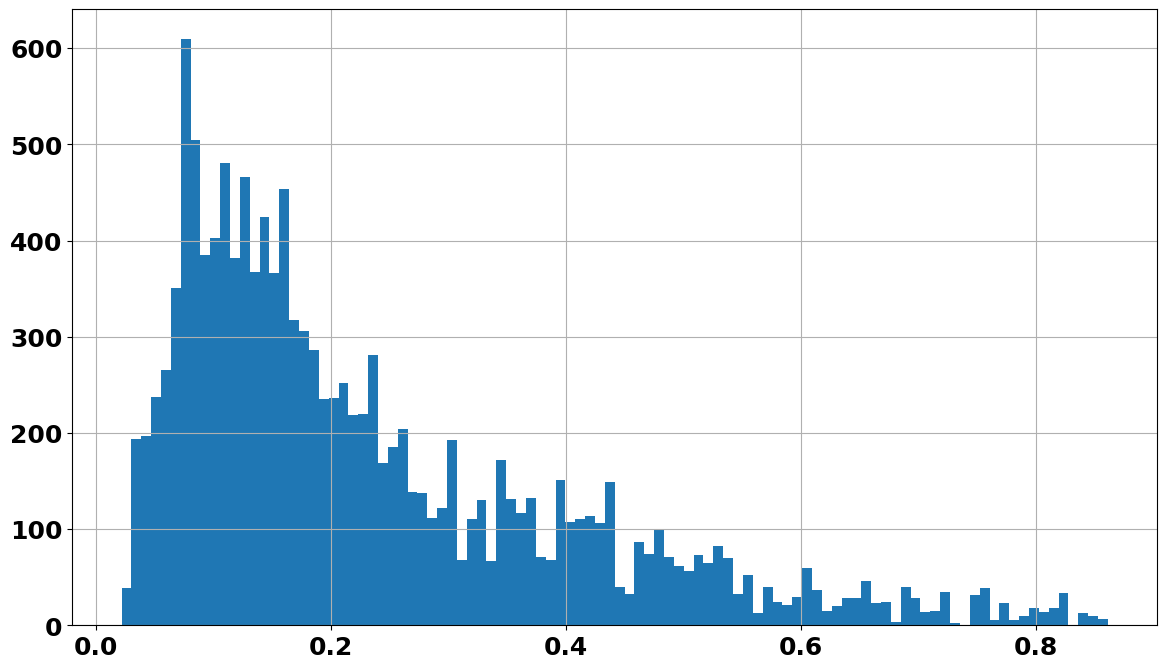

In [77]:
best_sub['score'].hist(bins=100)

In [ ]:
tab_scores_ = tab_scores[:4] + [0]
tab_final_p =  sum([w * p for w, p in zip(tab_scores_, test_preds["tabnet"])]) / sum(tab_scores_)

<Axes: ylabel='Count'>

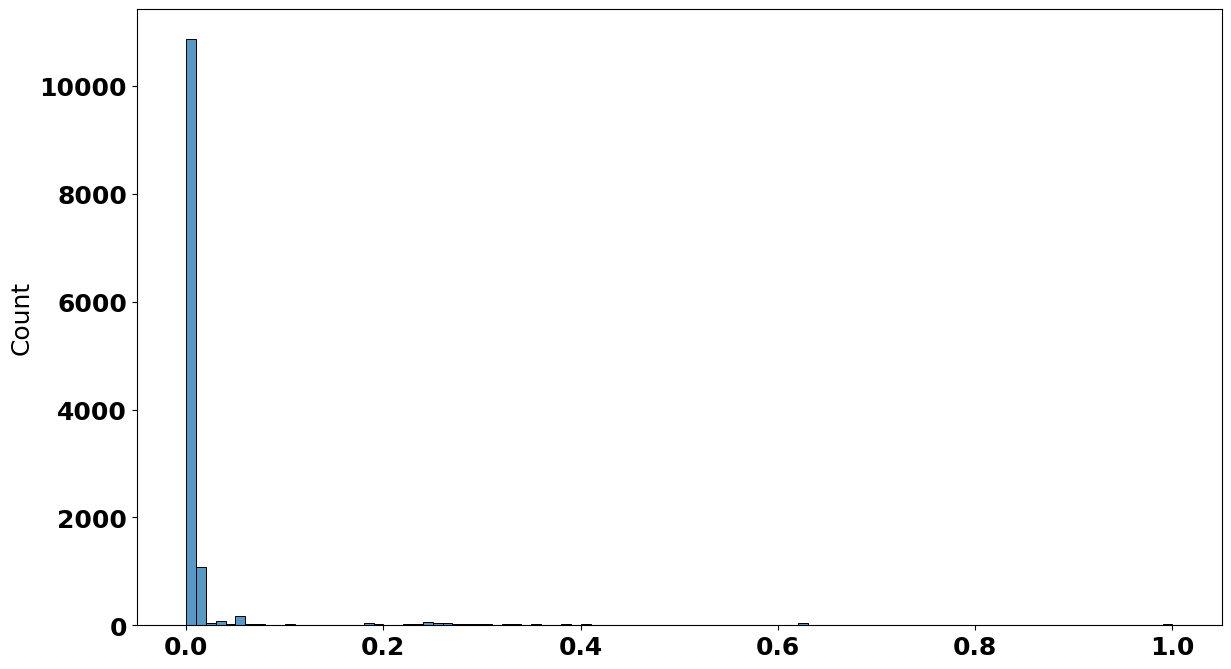

In [ ]:
sns.histplot(
    test_preds["tabnet"][2],
    bins=100,
)

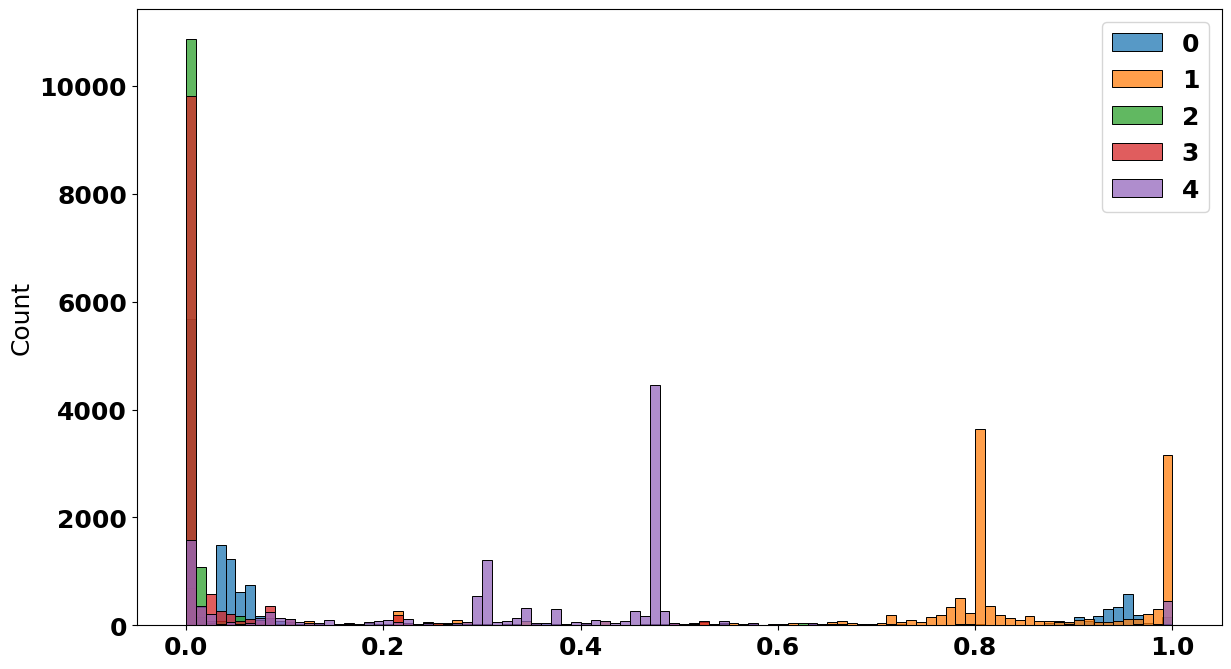

In [ ]:
for i in range(5):
  sns.histplot(
      test_preds["tabnet"][i],
      bins=100,
      label=f'{i}'
  )
plt.legend()

In [ ]:
sample_submit = deepcopy(pd.read_csv('test2_X.csv')[["contract_id", "report_date"]])

make_res_inv = False

if make_res_inv:
  tab_final_p = 1 - tab_final_p

sample_submit["score"] = test_preds["tabnet"][2]

print(sample_submit.head(5))

   contract_id report_date     score
0         3029  2023-07-30  0.000009
1         4350  2023-07-30  0.000482
2         1095  2023-07-30  0.003643
3         2634  2023-07-30  0.000012
4         6535  2023-07-30  0.000009


In [ ]:
if USING_COLAB:
  subs_path = "/content/subs"
else:
  subs_path = "subs"

if not os.path.exists(subs_path):
  os.mkdir(subs_path)

sub_name = "tabnet_3"
sample_submit.to_csv(f"{subs_path}/{sub_name}.csv", index=False)